This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## A temperature-forecasting example

### Libraries

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.get_logger().setLevel("ERROR")
#tf.get_logger().setLevel('INFO')



2022-11-14 11:36:46.310259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 11:36:46.524570: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-14 11:36:46.560541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 11:36:46.560555: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

### GPU settings

In [5]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

GPU name:  []
Num GPUs Available:  0


### Working directory

In [2]:
# Get the current working directory
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

# Change the current working directory
#os.chdir('/home/rodralez/')
#os.chdir('/home/rodralez/my/docencia/ia2/ia2/05_rnn')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/rodralez/my/docencia/ia2/ia2/05_rnn
Current working directory: /home/rodralez/my/docencia/ia2/ia2/05_rnn


### Downloading the data

In [31]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/rodralez/.wget-hsts'. HSTS will be disabled.
--2022-10-31 18:43:37--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.29.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.29.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  3.15MB/s    in 5.5s    

2022-10-31 18:43:43 (2.34 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Inspecting the data of the Jena weather dataset 

In [3]:
fname = os.path.join("./jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print('Number of lines:', len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of lines: 420451


### Parsing the data

Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column.

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

### Plotting the temperature timeseries

Figure shows the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature—the data spans 8 years.

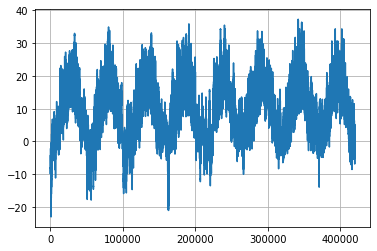

In [5]:
plt.plot(range(len(temperature)), temperature)
plt.grid()

**Plotting the first 10 days of the temperature timeseries**

Figure shows a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day. On this plot, you can see daily periodicity, especially for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

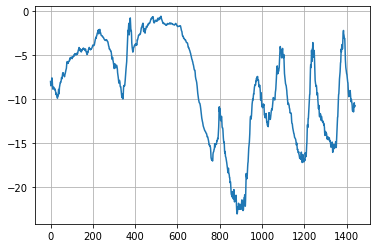

In [11]:
plt.plot(range(1440), temperature[:1440])
plt.grid()

### Computing the number of samples we'll use for each data split

In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that.

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### The exact formulation of the problem

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

### Preparing the data

**Normalizing the data**

First, let’s preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Next, let’s create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future.

**Understanding `timeseries_dataset_from_array()` with a dummy dataset**

In [48]:
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing.

We’ll use the following parameter values:

* `sampling_rate` = 6, Observations will be sampled at one data point per hour:
we will only keep one data point out of 6.
* `sequence_length` = 120, Observations will go back 5 days (120 hours).
*   `delay` = `sampling_rate * (sequence_length + 24 - 1)`, The target for a sequence will be the temperature 24 hours after the end of the sequence.

**Instantiating datasets for training, validation, and testing**

In [7]:
sampling_rate = 6 
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2022-11-14 11:38:07.859775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-14 11:38:07.859805: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 11:38:07.859821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thinkpad): /proc/driver/nvidia/version does not exist
2022-11-14 11:38:07.860227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1] aren’t necessarily temporally close.

**Inspecting the output of one of our datasets**

In [8]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
train_dataset

samples shape: (256, 120, 14)
targets shape: (256,)


<BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### A common-sense, non-machine-learning baseline

A common-sense approach is to alwayspredict that the temperature 24 hours from now will be equal to the temperature right now. Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [10]:
print(raw_data.shape)

(420451, 14)


In [11]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 8s 9ms/step - loss: 15.7084 - mae: 3.0542 - val_loss: 14.1343 - val_mae: 2.9843
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 10.2852 - mae: 2.5216 - val_loss: 10.3524 - val_mae: 2.5471
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 9.2011 - mae: 2.3902 - val_loss: 11.9505 - val_mae: 2.7555
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 8.6366 - mae: 2.3182 - val_loss: 11.0008 - val_mae: 2.6461
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 8.2415 - mae: 2.2648 - val_loss: 10.6381 - val_mae: 2.5961
Epoch 6/10
819/819 [==============================] - 9s 10ms/step - loss: 7.9154 - mae: 2.2185 - val_loss: 12.4968 - val_mae: 2.8316
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.6805 - mae: 2.1874 - val_loss: 12.8927 - val_mae: 2.8569
Epoch 8/10
819/819 [==============================] - 10s 12m

**Plotting results**

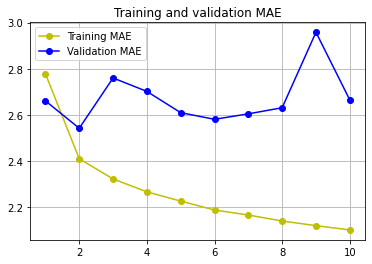

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "-yo", label="Training MAE")
plt.plot(epochs, val_loss, "-bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.grid()
plt.show()

### Let's try a 1D convolutional model

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 23.7221 - mae: 3.7716 - val_loss: 22.5393 - val_mae: 3.8229
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 15.3813 - mae: 3.1107 - val_loss: 16.6117 - val_mae: 3.2457
Epoch 3/10
819/819 [==============================] - 14s 16ms/step - loss: 14.1835 - mae: 2.9852 - val_loss: 18.3017 - val_mae: 3.3527
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 13.4366 - mae: 2.9010 - val_loss: 17.4317 - val_mae: 3.2646
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 12.7423 - mae: 2.8247 - val_loss: 15.5737 - val_mae: 3.1127
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 12.1998 - mae: 2.7648 - val_loss: 17.4709 - val_mae: 3.3508
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 11.7185 - mae: 2.7119 - val_loss: 17.5023 - val_mae: 3.2854
Epoch 8/10
819/819 [============================

**Plotting results**

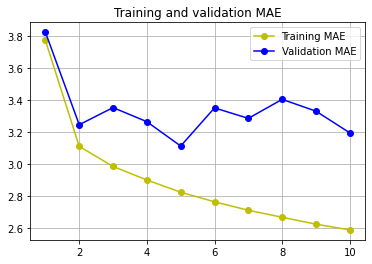

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "-yo", label="Training MAE")
plt.plot(epochs, val_loss, "-bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.grid()
plt.show()

### A first recurrent baseline

**A simple LSTM-based model**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 31s 37ms/step - loss: 42.3707 - mae: 4.7448 - val_loss: 12.4754 - val_mae: 2.6839
Epoch 2/10
819/819 [==============================] - 32s 39ms/step - loss: 11.1499 - mae: 2.5963 - val_loss: 9.7871 - val_mae: 2.4334
Epoch 3/10
819/819 [==============================] - 33s 40ms/step - loss: 10.2101 - mae: 2.4961 - val_loss: 9.7069 - val_mae: 2.4253
Epoch 4/10
819/819 [==============================] - 33s 41ms/step - loss: 9.8661 - mae: 2.4484 - val_loss: 9.5903 - val_mae: 2.4143
Epoch 5/10
819/819 [==============================] - 33s 41ms/step - loss: 9.5903 - mae: 2.4103 - val_loss: 9.7428 - val_mae: 2.4303
Epoch 6/10
819/819 [==============================] - 33s 40ms/step - loss: 9.3611 - mae: 2.3797 - val_loss: 9.6697 - val_mae: 2.4147
Epoch 7/10
819/819 [==============================] - 33s 40ms/step - loss: 9.1742 - mae: 2.3562 - val_loss: 9.7589 - val_mae: 2.4132
Epoch 8/10
819/819 [==============================] - 33s 

**Plotting results**

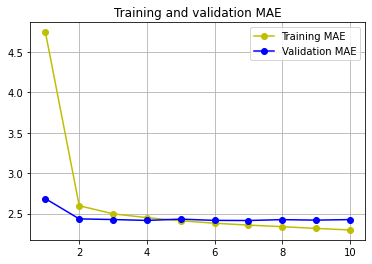

In [22]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "-yo", label="Training MAE")
plt.plot(epochs, val_loss, "-bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.grid()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [26]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [30]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [31]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [32]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [1]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

NameError: name 'keras' is not defined

**Plotting results**

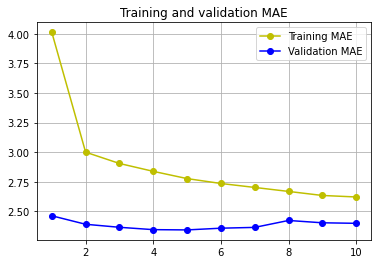

In [24]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "-yo", label="Training MAE")
plt.plot(epochs, val_loss, "-bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.grid()
plt.show()

In [33]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 111s 133ms/step - loss: 21.7721 - mae: 3.4069 - val_loss: 8.9856 - val_mae: 2.3157
Epoch 2/10
819/819 [==============================] - 112s 137ms/step - loss: 11.0520 - mae: 2.5899 - val_loss: 8.6448 - val_mae: 2.2743
Epoch 3/10
819/819 [==============================] - 110s 135ms/step - loss: 10.3274 - mae: 2.5079 - val_loss: 9.3818 - val_mae: 2.3721
Epoch 4/10
819/819 [==============================] - 108s 132ms/step - loss: 9.7873 - mae: 2.4456 - val_loss: 8.6443 - val_mae: 2.2728
Epoch 5/10
819/819 [==============================] - 108s 132ms/step - loss: 9.3285 - mae: 2.3892 - val_loss: 9.3198 - val_mae: 2.3701
Epoch 6/10
819/819 [==============================] - 106s 129ms/step - loss: 8.8267 - mae: 2.3248 - val_loss: 9.5585 - val_mae: 2.3898
Epoch 7/10
819/819 [==============================] - 116s 142ms/step - loss: 8.4279 - mae: 2.2708 - val_loss: 9.7075 - val_mae: 2.4168
Epoch 8/10
819/819 [=========================

**Plotting results**

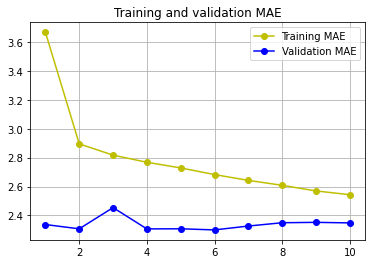

In [27]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "-yo", label="Training MAE")
plt.plot(epochs, val_loss, "-bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.grid()
plt.show()

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 29.1240 - mae: 3.8953 - val_loss: 11.6419 - val_mae: 2.6581
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 10.0088 - mae: 2.4694 - val_loss: 10.1971 - val_mae: 2.4837
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 8.9748 - mae: 2.3390 - val_loss: 10.0449 - val_mae: 2.4465
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 8.3636 - mae: 2.2570 - val_loss: 10.1770 - val_mae: 2.4701
Epoch 5/10
819/819 [==============================] - 47s 58ms/step - loss: 7.9602 - mae: 2.1989 - val_loss: 10.2380 - val_mae: 2.4709
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 7.5714 - mae: 2.1425 - val_loss: 10.5173 - val_mae: 2.5113
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 7.2948 - mae: 2.1019 - val_loss: 10.4850 - val_mae: 2.5133
Epoch 8/10
819/819 [==============================] -

**Plotting results**

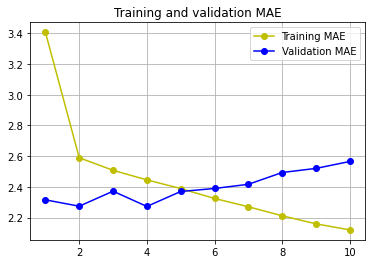

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "-yo", label="Training MAE")
plt.plot(epochs, val_loss, "-bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.grid()
plt.show()

### Going even further

## Summary